## Matrix Compeletion 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#  Load the dataset 
df = pd.read_csv(r"C:\Users\Yeabs\Downloads\final_suicide_2021 1(in).csv")

# Keep only numeric columns
X = df.select_dtypes(include=[np.number])

#  Define the matrix completion functions
def impute_with_col_means(X):
    X_ = X.copy()
    col_means = np.nanmean(X_, axis=0)
    missing_idx = np.where(np.isnan(X_))
    X_[missing_idx] = np.take(col_means, missing_idx[1])
    return X_

def fit_svd(X, M):
    U, s, VT = np.linalg.svd(X, full_matrices=False)
    return U[:, :M] @ (np.diag(s[:M]) @ VT[:M, :])

def matrix_completion(X, rel_error_threshold, M, max_iterations=10, verbose=False):
    missing_idx = np.isnan(X)
    X_tilde = impute_with_col_means(X)

    mss0 = np.mean(X[~missing_idx]**2)
    mss_prev = None
    iteration = 0
    rel_error = rel_error_threshold + 1

    while rel_error > rel_error_threshold and iteration < max_iterations:
        iteration += 1
        X_tilde_M = fit_svd(X_tilde, M)
        X_tilde[missing_idx] = X_tilde_M[missing_idx]
        mss = np.mean(np.square(X[~missing_idx] - X_tilde_M[~missing_idx]))

        if mss_prev is not None:
            rel_error = (mss_prev - mss) / mss0
            if verbose:
                print(f"Iteration {iteration}, MSS: {mss}, RelError: {rel_error}")
        mss_prev = mss

    return X_tilde


In [3]:
#  Standardize the data before matrix completion
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Matrix Completion
X_completed_scaled = matrix_completion(X_scaled, rel_error_threshold=1e-7, M=2, verbose=True)

#  Inverse scale back to original units
X_completed = scaler.inverse_transform(X_completed_scaled)

#  Save or preview results
X_completed_df = pd.DataFrame(X_completed, columns=X.columns)
X_completed_df.head()


Iteration 2, MSS: 0.31437681937454626, RelError: 0.0006300633745709437
Iteration 3, MSS: 0.31416617130351504, RelError: 0.00021064807103121636
Iteration 4, MSS: 0.31409357829929746, RelError: 7.25930042175804e-05
Iteration 5, MSS: 0.31406786073678744, RelError: 2.5717562510019214e-05
Iteration 6, MSS: 0.31405857053077624, RelError: 9.290206011203226e-06
Iteration 7, MSS: 0.3140551712923187, RelError: 3.3992384575465265e-06
Iteration 8, MSS: 0.3140539172452145, RelError: 1.2540471042155053e-06
Iteration 9, MSS: 0.31405345215289415, RelError: 4.6509232032310155e-07
Iteration 10, MSS: 0.3140532790730088, RelError: 1.7307988536829908e-07


,anxiety_percent,bipolar_percent,depress_percent,suicide_rate_per100k,gdp_usd
0,0.030089,0.002371,0.025406,7.148372,12617.505100
1,0.049990,0.002573,0.041064,4.274235,12617.505100
2,0.031223,0.002446,0.023614,10.637906,-29040.379308
3,0.052123,0.002546,0.040503,7.770534,-25884.110520
4,0.022690,0.004234,0.026537,11.649648,3704.193559


## PCA

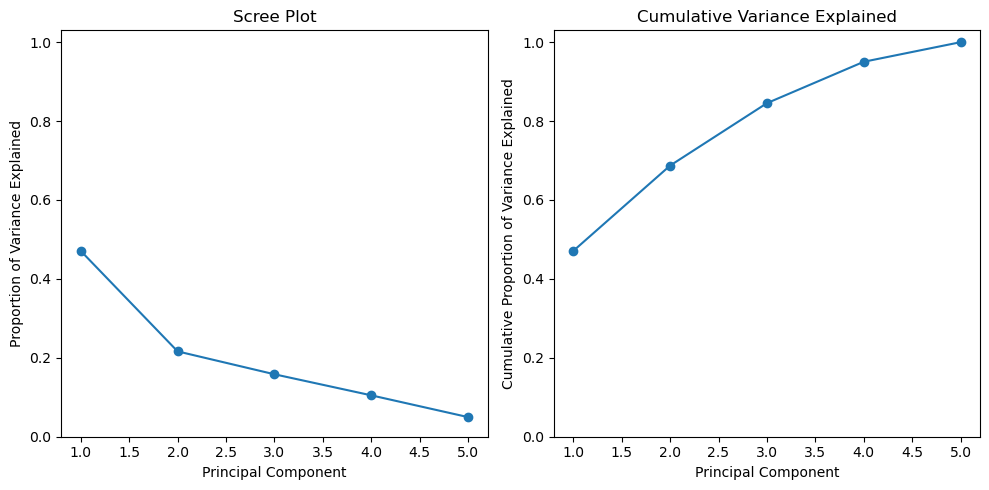

In [9]:
import matplotlib.pyplot as plt
 # Perform PCA using SVD on the standardized completed matrix
U, s, VT = np.linalg.svd(X_completed_scaled, full_matrices=False)
# Compute Proportion of Variance Explained (PVE) for each component
pve = s**2 / np.sum(s**2)  # Total variance is sum of squared singular values
#  Plot Scree Plot and Cumulative PVE
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Scree Plot (Individual variance explained)
ax[0].plot(np.arange(1, len(pve)+1), pve, marker="o")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Proportion of Variance Explained")
ax[0].set_ylim(0, 1.03)
ax[0].set_title("Scree Plot")
# Cumulative Proportion of Variance Explained
ax[1].plot(np.arange(1, len(pve)+1), np.cumsum(pve), marker="o")
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Cumulative Proportion of Variance Explained")
ax[1].set_ylim(0, 1.03)
ax[1].set_title("Cumulative Variance Explained")
plt.tight_layout()
plt.show()


The first principal component (PC1) explains around 47% of the variance in the dataset, suggesting it's the most dominant direction of variability. This likely captures a general mental health burden across countries, as anxiety, depression, and bipolar disorder often correlate and jointly impact suicide rates. The second component (PC2) accounts for about 22% more, meaning together PC1 and PC2 explain nearly 70% of the total variance. This shows that a 2D representation of the data captures the majority of its structure, making dimensionality reduction a useful step for visualization and clustering.
As we move to the third and fourth components, the additional variance explained becomes less significant (around 16% and 10%, respectively), suggesting diminishing returns in capturing structure. The fifth component contributes very little (~5%), indicating it mostly reflects noise or minor variance.

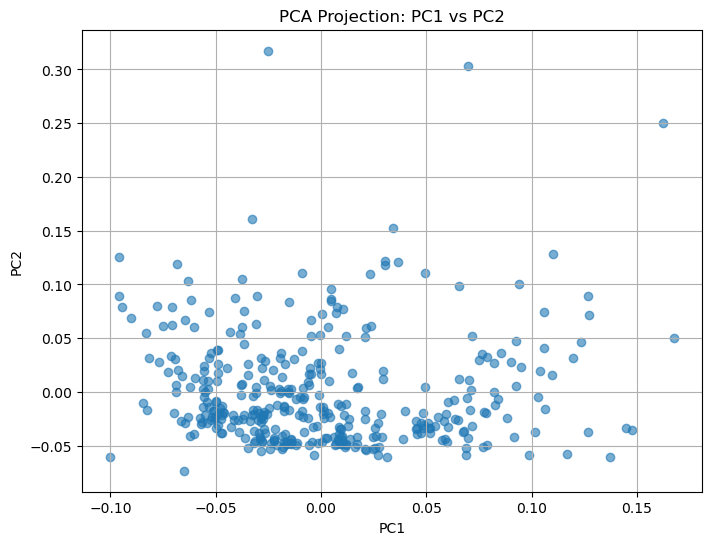

In [11]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(U[:, 0], U[:, 1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection: PC1 vs PC2")
plt.grid(True)
plt.show()


The PCA projection reveals the distribution of countries in the reduced 2D space defined by the first and second principal components. Most of the points are clustered around the center, especially near zero on the PC1 axis, indicating that a majority of countries share similar profiles in terms of mental health prevalence and economic indicators. However, the spread along both PC1 and PC2 suggests variation some countries differ more significantly, either due to extreme values in suicide rates, mental illness prevalence, or GDP. 

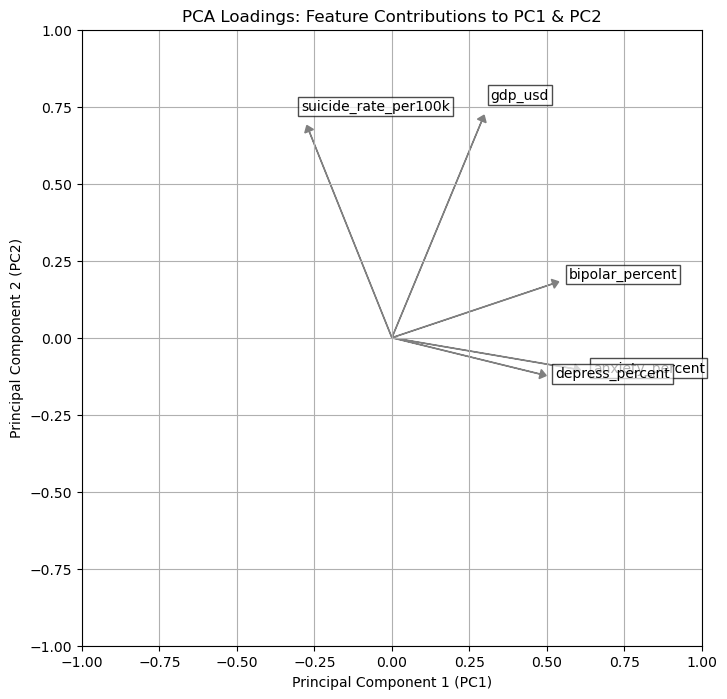

In [17]:


import matplotlib.pyplot as plt

# Create PCA loading plot shows how each feature contributes to PC1 and PC2
fig, ax = plt.subplots(figsize=(8, 8))

# Set axes limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Feature names 
feature_names = X.columns 

# Plot arrows and labels for each feature
for i, (loading, feature) in enumerate(zip(VT.T, feature_names)):
    ax.arrow(0, 0, loading[0], loading[1], 
             head_width=0.03, head_length=0.02, fc='gray', ec='gray')
    ax.text(loading[0]*1.1, loading[1]*1.1, feature,
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 2})
# Label the axes
ax.set_xlabel("Principal Component 1 (PC1)")
ax.set_ylabel("Principal Component 2 (PC2)")
ax.set_title("PCA Loadings: Feature Contributions to PC1 & PC2")
ax.grid(True)
plt.show()


PC1 (horizontal axis) seems to represent a general mental health burden dimension.Anxiety, Depression, and Bipolar disorder percentages all point strongly in the positive PC1 direction, meaning they tend to increase together.So, countries with high PC1 scores likely have higher reported rates of mental health conditions.

PC2 (vertical axis) is shaped mostly by Suicide rate and GDP ,Suicide rate per 100k and GDP both point upward, contributing positively to PC2.
This might suggest that in some cases, higher economic wealth (GDP) comes with higher suicide rates, or that these factors vary together in your dataset

Since Depression, Bipolar, and Anxiety point in roughly the same direction, they’re positively correlated countries with high depression rates also tend to have high anxiety and bipolar rates.GDP and Suicide rate are also pointing in the same direction, meaning they may be positively associated in this dataset.But the mental health percentages and Suicide rate/GDP form an angle so while related, they might reflect different dimensions of the problem.

In [21]:
loadings = pd.DataFrame(VT.T, index=X.columns, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])

loadings

,PC1,PC2,PC3,PC4,PC5
anxiety_percent,0.588642,-0.101015,0.147540,0.084225,-0.783859
bipolar_percent,0.519062,0.175179,-0.203135,0.703522,0.404574
depress_percent,0.478320,-0.118082,0.628162,-0.400678,0.449595
suicide_rate_per100k,-0.266986,0.670519,0.613567,0.287966,-0.140474
gdp_usd,0.289834,0.703966,-0.407328,-0.504476,-0.003941


The magnitudes of the loadings tell us which features are the most significant in the principal components.
- **PC1**is mostly about overall mental health burden. Countries with higher anxiety, depression, bipolar rates and even GDP score high here. Suicide rates go slightly the other way.
- **PC2** links suicide rates and GDP. So, countries with high GDP and high suicide rates stand out here. Mental health conditions don’t play a big role in this one.
- **PC3** is a mix of high depression and suicide rates, suggesting these two often go together. GDP and bipolar rates are less influential here.
- **PC4** highlights bipolar disorder, with GDP pulling the other way so it may show bipolar trends unrelated to a country’s wealth.
- **PC5** contrasts anxiety with depression and bipolar. Some countries may have more bipolar and depression compared to anxiety.



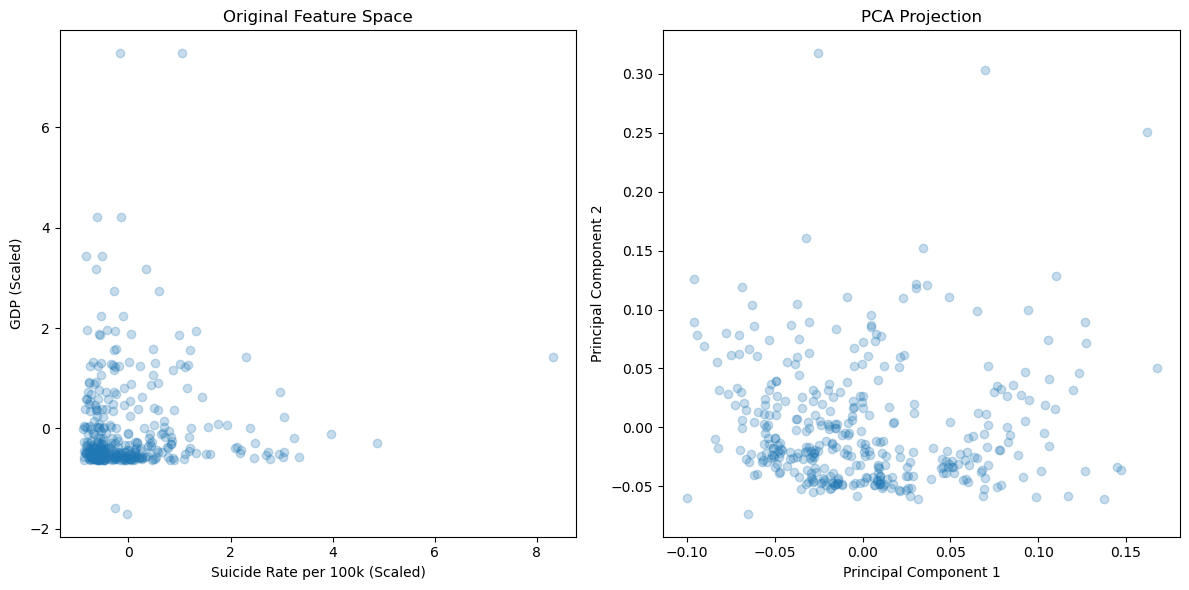

In [33]:
import matplotlib.pyplot as plt

column_names = ['anxiety_percent', 'bipolar_percent', 'depress_percent', 'suicide_rate_per100k', 'gdp_usd']

X_scaled_df = pd.DataFrame(X_completed_scaled, columns=column_names)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot two raw features on the left
ax[0].scatter(X_scaled_df['suicide_rate_per100k'], X_scaled_df['gdp_usd'], alpha=0.25)
ax[0].set_xlabel("Suicide Rate per 100k (Scaled)")
ax[0].set_ylabel("GDP (Scaled)")
ax[0].set_title("Original Feature Space")

# PCA scores from SVD (U matrix)
ax[1].scatter(U[:, 0], U[:, 1], alpha=0.25)
ax[1].set_xlabel("Principal Component 1")
ax[1].set_ylabel("Principal Component 2")
ax[1].set_title("PCA Projection")

plt.tight_layout()
plt.show()


#### **Left Plot: Original Feature Space**

In this scatter plot, each point represents a country-year pair plotted by **suicide rate per 100k** (x-axis) and **GDP (scaled)** (y-axis).

* Most of the data is **clustered near the origin**, meaning that for many countries, suicide rates and GDP levels (after scaling) are moderate or close to average.
* However, there are a few **extreme outliers**, especially on the **suicide rate axis** (points far to the right) and some with extremely high GDP (top area). These outliers may be countries with economic anomalies or extremely high suicide reporting.
* There's **no clear linear relationship** between GDP and suicide rate  if anything, countries with higher suicide rates often have a **lower GDP**, suggesting that wealth alone may not prevent high suicide burdens.

#### **Right Plot: PCA Projection (PC1 vs PC2)**

This plot shows the same data transformed into **principal components** these are the directions that explain the most variation in the whole dataset, not just GDP and suicide.

* **PC1 (x-axis)** is heavily influenced by mental health disorder prevalence (`anxiety`, `bipolar`, `depression`) and `gdp_usd` it captures overall **mental health and economic burden**.
* **PC2 (y-axis)** is more influenced by `suicide_rate_per100k` and `gdp_usd`, meaning it captures **suicide risk and socioeconomic stress**.
* Most points again cluster near the origin, but **the spread is more even**, and some patterns of separation start to appear  this suggests **some structure in the data** that wasn’t visible in the raw features.
* **Outliers are easier to detect** here, and the compactness of the main cluster confirms that PCA has **compressed** the meaningful variation into just two components, which can now be used for clustering or further analysis.



## Kmean clusters 

C:\Users\Yeabs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yeabs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yeabs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Yeabs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Window

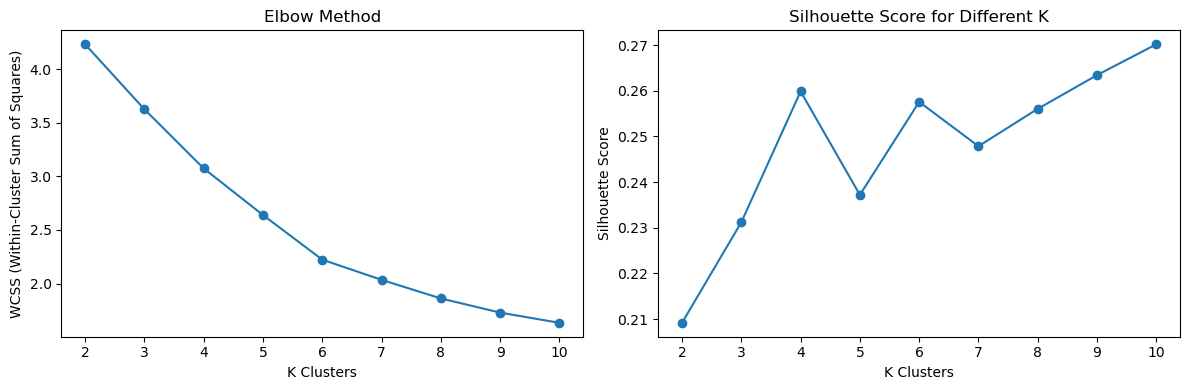

In [38]:
# Function to compute Within-Cluster Sum of Squares (WCSS) and Silhouette Score
def compute_metrics(k):
    kmeans_model = KMeans(n_clusters=k, random_state=3, n_init=20).fit(U)
    sil_score = metrics.silhouette_score(U, kmeans_model.labels_, metric="euclidean")
    return kmeans_model.inertia_, sil_score

# Try different values of K (number of clusters)
ks = np.arange(2, 11)
WCSS, SS = zip(*[compute_metrics(k) for k in ks])

# Plot WCSS and Silhouette Score to help select optimal K
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Elbow method plot
ax[0].plot(ks, WCSS, linestyle="-", marker="o")
ax[0].set_xlabel("K Clusters")
ax[0].set_ylabel("WCSS (Within-Cluster Sum of Squares)")
ax[0].set_title("Elbow Method")

# Silhouette Score plot
ax[1].plot(ks, SS, linestyle="-", marker="o")
ax[1].set_xlabel("K Clusters")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Silhouette Score for Different K")

plt.tight_layout()
plt.show()


 - The elbow plot shows a clear bend at K = 4, meaning adding more clusters doesn’t help much. The silhouette score also peaks around K = 4, suggesting this is the best choice.Thus K = 4 is the optimal number of clusters for our data.

C:\Users\Yeabs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


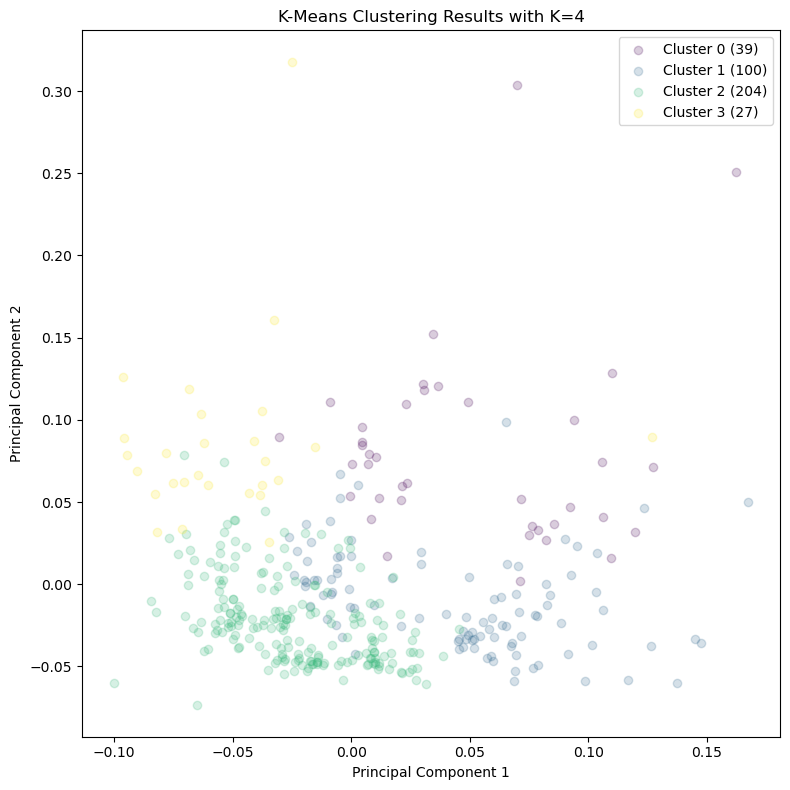

In [42]:
# Fit KMeans with 4 clusters on the PCA-reduced data (U)
kmeans = KMeans(n_clusters=4, random_state=5322, n_init=20).fit(U)

# Plot KMeans clustering results on the first two principal components
fig, ax = plt.subplots(figsize=(8, 8))

# Get unique cluster labels and assign colors
unique_labels = np.unique(kmeans.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Plot each cluster with a different color
for i, label in enumerate(unique_labels):
    mask = kmeans.labels_ == label
    ax.scatter(
        U[mask, 0],  # PC1
        U[mask, 1],  # PC2
        alpha=0.2,
        c=[colors[i]],
        label=f"Cluster {label} ({np.sum(mask)})"
    )

# Add titles and labels
ax.set_title("K-Means Clustering Results with K=4")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend()
plt.tight_layout()
plt.show()


When we ran K-Means with 4 clusters, the algorithm grouped countries into 4 patterns based on how similar they are across suicide rate, GDP, and mental health disorder rates (anxiety, depression, bipolar). Here's what each cluster seems to represent:

- **Cluster 2 (204 countries)** is the biggest group. These countries share more “average” patterns nothing extreme. Think of them as balanced: not too high or low in suicide rates, GDP, or mental health percentages.

- **Cluster 1 (100 countries)** is tighter and leans to the right in the plot. These countries likely have higher GDP and more reported mental health disorders, but lower suicide rates. Could be developed countries with more diagnosis and reporting infrastructure.

- **Cluster 0 (39 countries)** sits more in the upper area of the plot, which is driven by PC2 (strongly tied to suicide rate and GDP). So, these might be places with elevated suicide rates possibly without high economic strength to offset it.

- **Cluster 3 (27 countries)** is scattered but mostly up and to the left, suggesting outlier behavior. These could be countries with low GDP but unexpectedly high suicide rates or mental health issues, or just extreme combinations not seen in the other groups.

In [47]:
np.random.seed(5322)

# Cluster 0
X[kmeans.labels_==0].iloc[np.random.choice(39,10)]

,anxiety_percent,bipolar_percent,depress_percent,suicide_rate_per100k,gdp_usd
205,0.088971,0.011530,0.080533,1.027709,71751.88312
135,0.090320,0.011651,0.079645,7.390850,52496.84417
136,0.048740,0.010123,0.059346,23.131344,53099.13514
156,0.072101,0.009405,0.050942,18.169485,93072.89251
81,0.124077,0.010242,0.091808,3.218547,105561.13750
205,0.088971,0.011530,0.080533,1.027709,71751.88312
145,0.097423,0.013236,0.073382,4.071367,69727.98737
114,0.068449,0.015370,0.059841,25.598084,60607.77886
140,0.062185,0.010003,0.036768,17.151144,53648.71907
96,0.028639,0.007977,0.027237,9.590229,79601.41296


In [59]:
# Cluster 1
X[kmeans.labels_==1].iloc[np.random.choice(100,10)]

,anxiety_percent,bipolar_percent,depress_percent,suicide_rate_per100k,gdp_usd
164,0.051563,0.011570,0.053819,25.799929,17912.510620
217,0.124692,0.013107,0.043722,1.938852,6826.972007
141,0.112173,0.013142,0.064353,4.568992,53648.719070
130,0.061831,0.009932,0.035822,6.046716,33734.292970
159,0.086446,0.012830,0.065381,5.839723,1835.443941
164,0.051563,0.011570,0.053819,25.799929,17912.510620
210,0.048938,0.011058,0.037602,18.858999,4642.607431
126,0.057252,0.009242,0.036287,21.255442,10738.017920
209,0.099465,0.010072,0.079543,0.488496,19403.460020
126,0.057252,0.009242,0.036287,21.255442,10738.017920


In [61]:
# Cluster 2
X[kmeans.labels_==2].iloc[np.random.choice(204,10)]

,anxiety_percent,bipolar_percent,depress_percent,suicide_rate_per100k,gdp_usd
3,0.052123,0.002546,0.040503,7.770534,NaN
255,0.067276,0.008118,0.064717,2.981963,910.947840
45,0.064869,0.003440,0.044557,14.276851,1996.869768
345,0.064493,0.003532,0.040142,5.571612,15236.160490
11,0.072177,0.004345,0.049397,8.726533,3999.337647
309,0.065893,0.007712,0.069384,2.507659,1159.856567
59,0.038261,0.006782,0.057483,7.679720,9983.601036
57,0.046312,0.006923,0.056276,2.333603,5083.606955
313,0.047107,0.006260,0.070508,3.656537,660.747193
246,0.046869,0.007600,0.044853,6.867209,1584.124502


In [63]:
# Cluster 3
X[kmeans.labels_==3].iloc[np.random.choice(27,10)]

,anxiety_percent,bipolar_percent,depress_percent,suicide_rate_per100k,gdp_usd
58,0.023754,0.006382,0.042937,41.051000,9983.601036
356,0.039546,0.003395,0.038717,58.880416,14989.664750
100,0.049598,0.006540,0.055605,36.635050,7489.718947
314,0.051849,0.007012,0.055779,36.135678,6843.399419
302,0.054732,0.006846,0.051378,26.883297,4412.835569
48,0.021485,0.006332,0.047907,37.433502,4517.615780
192,0.053028,0.011497,0.062003,44.145901,5029.848385
318,0.047596,0.006772,0.036880,40.841748,1724.387731
112,0.043060,0.006528,0.048199,50.323146,12521.522460
110,0.055691,0.006482,0.059644,47.865245,23934.728490


- **Cluster 0 (39 countries)**
This group seems to be made up of wealthy countries with high GDP per capita, moderate levels of mental health issues, and varying suicide rates. Think of countries like the Netherlands or Sweden strong economies, well-documented health systems, and data infrastructure that captures a lot. Interestingly, a few countries show very high suicide rates despite high GDP.

- **Cluster 1 (100 countries)**
These are mid-GDP countries with a mix of mental health rates, but overall moderate to high suicide rates. This group includes both rising economies and struggling ones places where suicide may be rising despite development, or where mental health services are limited or underused.

- **Cluster 2 (204 countries)**
This is your “typical” cluster most countries fall here. The GDPs are generally low to mid, suicide rates are moderate, and mental health rates are in the middle range. Nothing extreme these are countries not standing out in any direction, which is why they cluster so closely.

- **Cluster 3 (27 countries)**
This group is filled with outliers. Suicide rates are very high, while GDPs are low to moderate. Mental health issues like anxiety and depression don’t seem unusually high, which might point to underreporting or lack of diagnosis infrastructure. These could be countries in crisis, either economic or social, where suicide rates are disproportionately elevated.

## Hierarchical Clustering

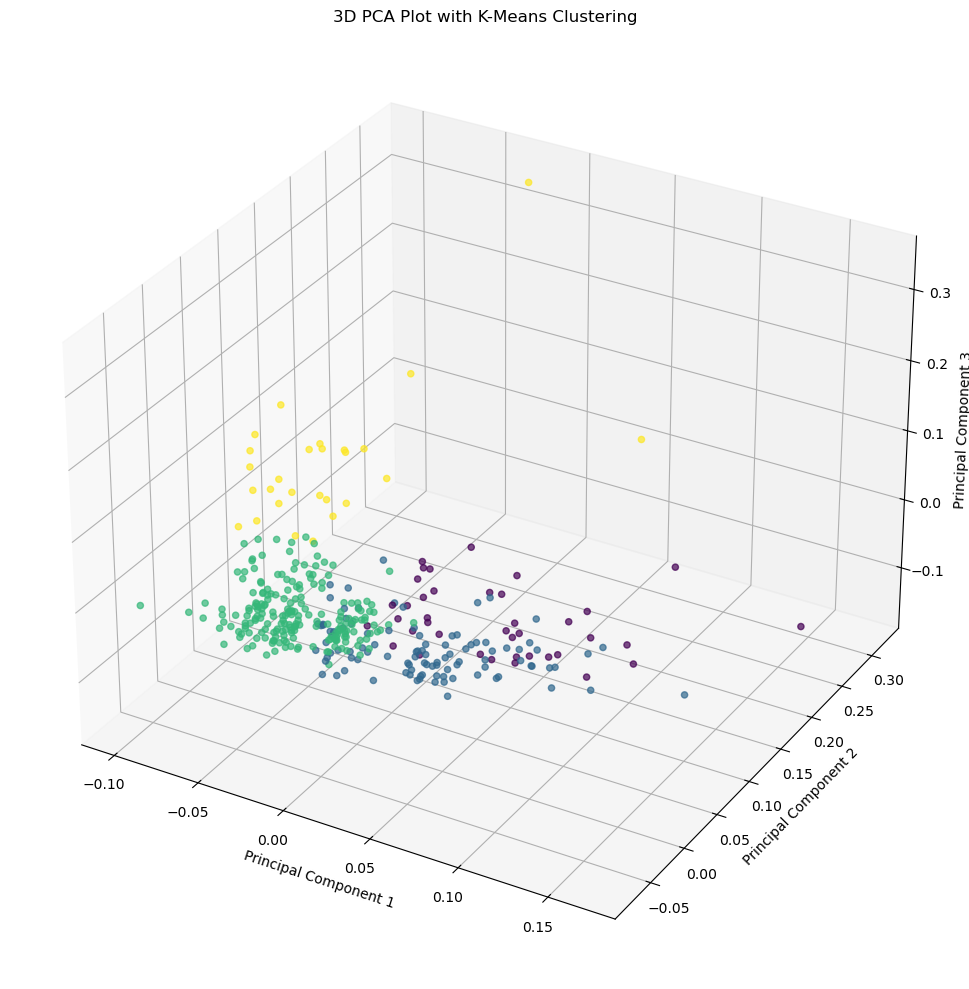

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter Plot of K-means Clusters using the first 3 PCs
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Color by cluster label
scatter = ax.scatter(
    U[:, 0],  # PC1
    U[:, 1],  # PC2
    U[:, 2],  # PC3
    c=kmeans.labels_,
    cmap="viridis",
    alpha=0.7
)

ax.set_title("3D PCA Plot with K-Means Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

plt.tight_layout()
plt.show()


The 3D PCA plot shows how countries cluster based on mental health indicators and GDP. Cluster 2, which contains the majority of countries, represents those with fairly average patterns moderate suicide rates, mental health disorder prevalence, and GDP levels. Cluster 1 includes countries that likely have higher GDP and better mental health reporting infrastructure, but relatively lower suicide rates. Cluster 0 seems to include countries with higher suicide rates and moderate economic performance. Finally, Cluster 3 stands out as a group of outliers countries with unusual combinations like very high suicide rates or very low GDP. This plot helps us visually understand how different nations group together based on key social and economic health factors.

## Hierarchical Clustering with Dendrograms (Scipy Version)

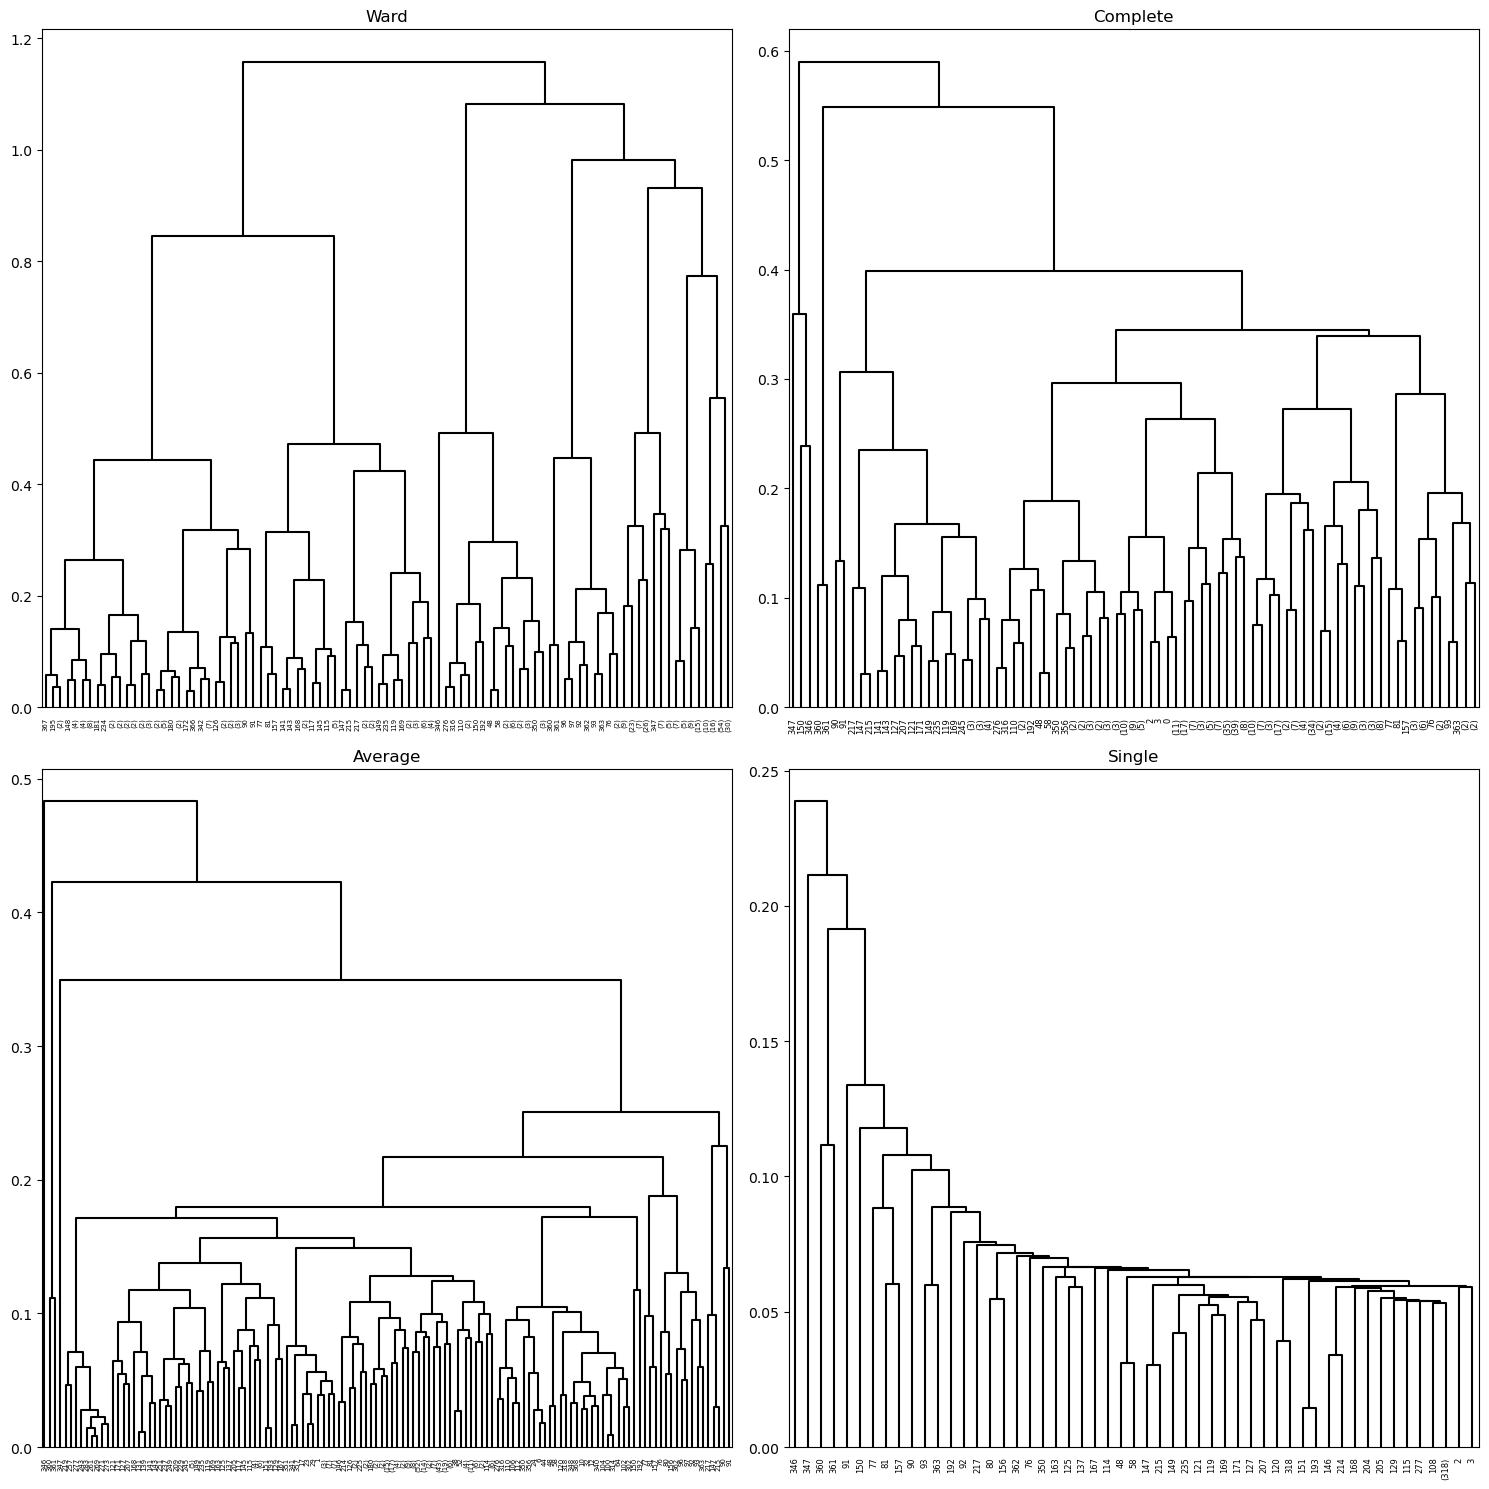

In [83]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

# Linkage matrices (for dendrograms)
linkage_ward = linkage(U, method='ward')
linkage_complete = linkage(U, method='complete')
linkage_average = linkage(U, method='average')
linkage_single = linkage(U, method='single')

# Plot the dendrograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
cargs = {"color_threshold": -np.inf, "above_threshold_color": "black"}

axes[0, 0].set_title("Ward")
dendrogram(linkage_ward, truncate_mode="level", p=6, ax=axes[0, 0], **cargs)

axes[0, 1].set_title("Complete")
dendrogram(linkage_complete, truncate_mode="level", p=8, ax=axes[0, 1], **cargs)

axes[1, 0].set_title("Average")
dendrogram(linkage_average, truncate_mode="level", p=13, ax=axes[1, 0], **cargs)

axes[1, 1].set_title("Single")
dendrogram(linkage_single, truncate_mode="level", p=30, ax=axes[1, 1], **cargs)

plt.tight_layout()
plt.show()


Among the four linkage methods, Ward linkage gives the most balanced and interpretable dendrogram structure. It forms clear, compact clusters that are relatively evenly spaced. This makes Ward a strong candidate for choosing the number of clusters (e.g., 4), especially since it aligns well with the K-means results.
Complete and average linkage also show some structure but with more variation in cluster size and less separation between groups. Single linkage, on the other hand, creates a very unbalanced "chain-like" structure this often leads to poor clustering because it links nearest neighbors without forming meaningful groups.

So overall, Ward linkage is the most reliable method here for extracting consistent, compact clusters from your PCA-reduced mental health and socioeconomic data.



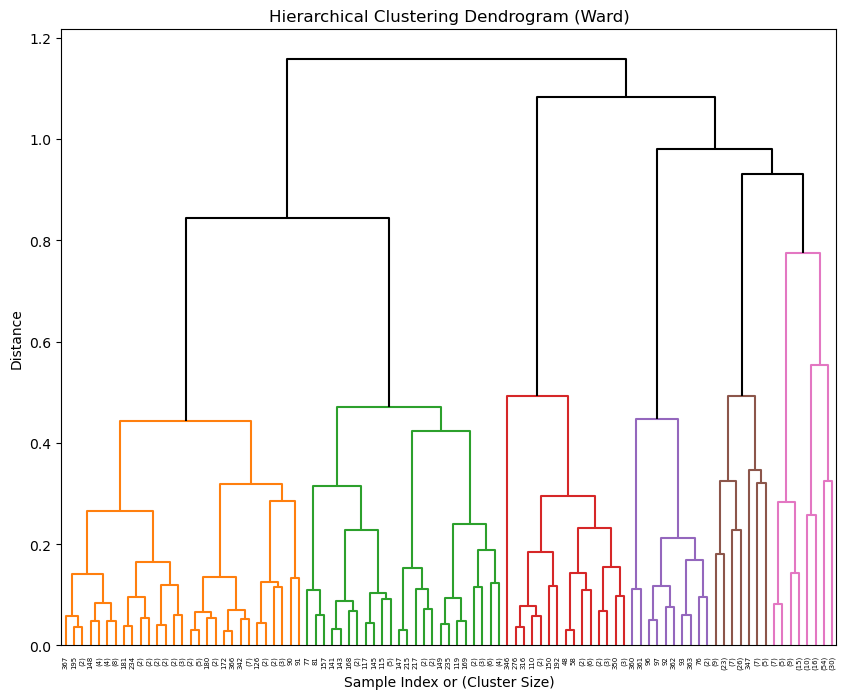

In [92]:
# Plot the dendrogram
fig, ax = plt.subplots(figsize=(10, 8))
dendrogram(
    linkage_ward,
    truncate_mode="level", p=6,
    ax=ax,
    color_threshold=0.8,
    above_threshold_color='black'
)
ax.set_title("Hierarchical Clustering Dendrogram (Ward)")
ax.set_xlabel("Sample Index or (Cluster Size)")
ax.set_ylabel("Distance")
plt.show()

The vertical height of the merges reflects how different those groups are: the higher the merge, the more distinct the clusters. Overall, the structure supports the four cluster solution from K-Means, confirming meaningful divisions in the data that reflect real-world mental health and economic patterns.










In [101]:
from sklearn.metrics import confusion_matrix 
# Apply cut_tree to get 4 clusters from the hierarchical clustering
cut4 = cut_tree(linkage_ward, n_clusters=4).flatten()

# Manually determine translation to match KMeans clusters
translation = {0: 0, 1: 2, 2: 3, 3: 1}  # may need tuning based on actual alignment
cut4_mapped = np.array([translation[x] for x in cut4])

# Compute confusion matrix comparing hierarchical clusters and KMeans clusters
cm = pd.DataFrame(confusion_matrix(cut4_mapped, kmeans.labels_))
cm.index = pd.Index([0, 1, 2, 3], name="dendrogram")
cm.columns.name = "k-means"

cm

k-means,0,1,2,3
dendrogram,,,,
0,18,7,198,1
1,10,93,5,0
2,0,0,1,26
3,11,0,0,0



This confusion matrix compares the clusters formed by **hierarchical clustering (rows)** and **K-means clustering (columns)**, both using 4 clusters. Overall, the results are fairly consistent across methods with some overlap.

* **Dendrogram Cluster 0** (the largest group) mostly overlaps with **K-means Cluster 2**, meaning these two methods agree that this group of countries shares similar characteristics.
* **Dendrogram Cluster 1** lines up well with **K-means Cluster 1**, showing high consistency (93 matched samples), likely representing countries with higher GDP and diagnosed mental health issues.
* **Dendrogram Cluster 2** overlaps almost entirely with **K-means Cluster 3**, both isolating extreme or outlier cases (like high suicide rates).
* **Dendrogram Cluster 3** doesn’t match well with any K-means cluster, suggesting these points were grouped differently possibly edge cases or noisy data.

This comparison shows that both clustering methods capture similar structure in the data but may differ slightly in how they group edge cases or outliers.


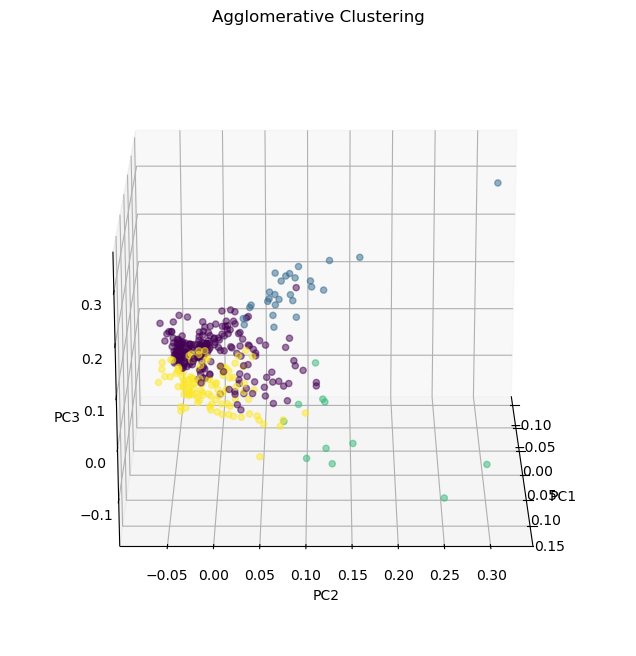

In [105]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter3D(
    U[:, 0],
    U[:, 1],
    U[:, 2],
    alpha=0.5,
    c=cut4,  # cluster labels from hierarchical clustering
    cmap='viridis'
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Agglomerative Clustering")

# Rotation animation function
def rotate(frame):
    ax.view_init(elev=20, azim=frame)
    return scatter,

# Create the rotation animation
animation = FuncAnimation(
    fig,
    rotate,
    frames=np.arange(0, 360, 2),
    interval=50,
    repeat=True
)

# Save as GIF
animation.save("agglomerative_clustering.gif", writer="pillow", fps=20)
